<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-06-26 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.6.0


# Compositon dependence of CR anisotropy
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
2. [Projected relative intensity](#Projected-relative-intensity)
3. [Cross-check: random splitting of events](#Cross-check:-random-splitting-of-events)

In [2]:
%matplotlib inline
from __future__ import division, print_function
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import multiprocessing as mp
from scipy.special import erfcinv

from icecube import astro

import comptools as comp
import comptools.analysis.plotting as plotting
import comptools.anisotropy.anisotropy as anisotropy

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
config = ['IC86.2012']
n_side = 64
smooth_rad = 20.0
scale = 3
decmax = -55
years_str = '2013'
composition='all'
low_energy = True

In [10]:
df_file = os.path.join(comp.paths.comp_data_dir, 'IC86.2012_data/anisotropy/random_trials/250trials/teststat_dataframe.hdf')
with pd.HDFStore(df_file, mode='r') as store:
    df = store.select('dataframe')

In [49]:
df = anisotropy.get_test_stats(config='IC86.2012', low_energy=True)

In [50]:
df

,pval,chi2
0,0.387281,2.889936
1,0.109433,5.519188
2,0.621609,2.193908
3,0.621609,1.369485
4,0.215977,4.283912
5,0.387281,0.890822
6,0.215977,5.918376
7,0.621609,13.788870
8,0.621609,0.886901
9,0.050588,13.947253


In [14]:
df.chi2.describe()

count    1000.000000
mean     2644.917953
std        12.794372
min      2611.413815
25%      2636.031899
50%      2644.414523
75%      2653.238260
max      2686.608491
Name: chi2, dtype: float64

In [51]:
def calc_chi2(ri_0, ri_1, ri_err_0, ri_err_1):
    chi2 = np.sum((ri_0-ri_1)**2/(ri_err_0**2+ri_err_1**2)) / ri_0.shape[0]
    return chi2

In [52]:
kwargs_relint = {'smooth': 20, 'scale': None, 'decmax': -55, 'low_energy': True}

relint_light = anisotropy.get_map(config=config, name='relint', composition='light', **kwargs_relint)
relint_heavy = anisotropy.get_map(config=config, name='relint', composition='heavy', **kwargs_relint)

relerr_light = anisotropy.get_map(config=config, name='relerr', composition='light', **kwargs_relint)
relerr_heavy = anisotropy.get_map(config=config, name='relerr', composition='heavy', **kwargs_relint)

ri_light, ri_err_light, ra, _ = anisotropy.get_proj_relint(relint_light, relerr_light, n_bins=24)
ri_heavy, ri_err_heavy, ra, _ = anisotropy.get_proj_relint(relint_heavy, relerr_heavy, n_bins=24)

chi2_data = calc_chi2(ri_light, ri_heavy, ri_err_light, ri_err_heavy)

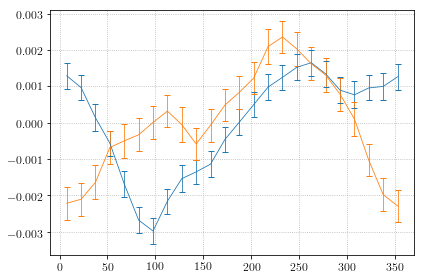

In [53]:
plt.errorbar(ra, ri_light, yerr=ri_err_light)
plt.errorbar(ra, ri_heavy, yerr=ri_err_heavy)
plt.grid()
plt.show()

In [54]:
chi2_data

10.209956821259928

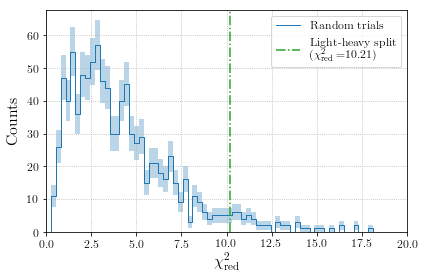

In [56]:
fig, ax = plt.subplots()
chi2_max = 20
chi2_bins = np.linspace(0, 20, 75)
counts = np.histogram(df.chi2, bins=chi2_bins)[0]
# ax = plotting.plot_steps(chi2_bins, counts, yerr=np.sqrt(counts))
ax = plotting.plot_steps(chi2_bins, counts, yerr=np.sqrt(counts), label='Random trials')
ax.axvline(chi2_data, marker='None', ls='-.', color='C2', lw=1.5,
           label='Light-heavy split \n ($\mathrm{\chi^2_{red}} = '+'${:0.2f})'.format(chi2_data))
# ax.text(1.0, 0.12, '{:0.2f}'.format(chi2_data))
ax.set_xlabel('$\mathrm{\chi^2_{red}}$')
ax.set_ylabel('Counts')
ax.set_ylim(0)
ax.set_xlim(0, chi2_max)
# ax.set_yscale("log", nonposy='clip')
ax.legend()
ax.grid()
plt.savefig(os.path.join(comp.paths.figures_dir, 'random-trials-chi2_IC86.2012.png'))
plt.show()

In [29]:
test_stat = df.chi2
pval = np.sum(test_stat > chi2_data)/len(test_stat)
print(pval)
significance = erfcinv(2*pval)*np.sqrt(2)
print(significance)

1.0
-inf


In [13]:
map_dir = '/data/user/jbourbeau/composition/IC86.2013_data/anisotropy/random_trials/test'
sample_0_file_pattern = os.path.join(map_dir, 'random_split_0_trial-*.fits')
sample_1_file_pattern = os.path.join(map_dir, 'random_split_1_trial-*.fits')
infiles_sample_0 = sorted(glob.glob(sample_0_file_pattern))
print(infiles_sample_0)
infiles_sample_1 = sorted(glob.glob(sample_1_file_pattern))

kwargs_relint = {'smooth': 20, 'scale': None, 'decmax': -55}
n_trials = 1

['/data/user/jbourbeau/composition/IC86.2013_data/anisotropy/random_trials/test/random_split_0_trial-0.fits']


NameError: name 'sample_0_trials' is not defined

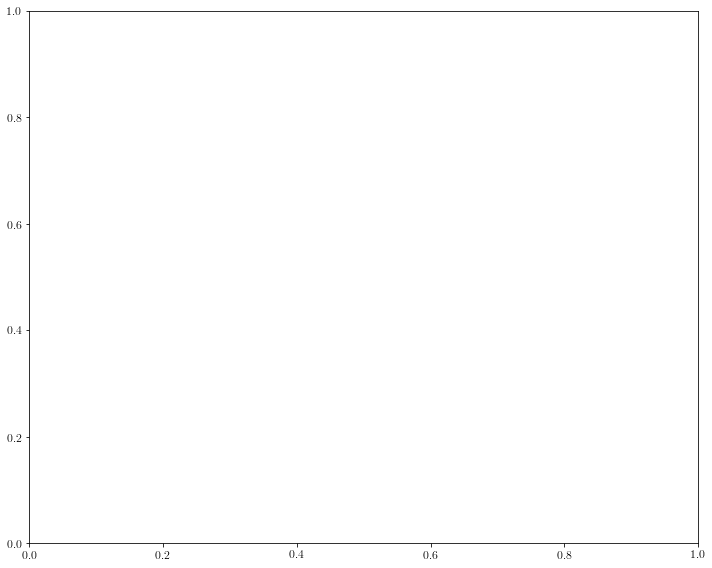

In [9]:
n = int(np.sqrt(n_trials))
fig, ax = plt.subplots(n, n, figsize=(10, 8), sharex=True, sharey=True)
# fig, axarr = plt.subplots(n, n, figsize=(10, 8), sharex=True, sharey=True)
# for trial, ax in enumerate(axarr.flatten()):
# trial = int(trial)
trial = 0
ra, ri_0, ri_err_0 = sample_0_trials[trial]
ra, ri_1, ri_err_1 = sample_1_trials[trial]

popt_0, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_0, sigmay=ri_err_0)
popt_1, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_1, sigmay=ri_err_1)

ax.errorbar(ra, ri_0, yerr=ri_err_0, label='Split 0', marker='.', ls=':', c='C3')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_0[:3]), color='C3', marker='None')

ax.errorbar(ra, ri_1, yerr=ri_err_1, label='Split 1', marker='.', ls=':', c='C4')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_1[:3]), color='C4', marker='None')

ax.axhline(0, marker='None', ls='-', c='k')
ax.invert_xaxis()

ax.set_title('$\mathrm{\chi^2_{red}}$'+' = {:0.2f}'.format(chi2_trials[trial]))
ax.grid()
#     ax.legend()

for i, row in enumerate(axarr):
    for j, cell in enumerate(row):
        if i == len(axarr) - 1:
            cell.set_xlabel('RA [ $^{\circ}$]')
        if j == 0:
            cell.set_ylabel('$\mathrm{\langle RI \\rangle }$')

plt.tight_layout()
# fig.text(0.5, 0.00, 'RA [ $^{\circ}$]', ha='center')
# fig.text(0.00, 0.5, '$\mathrm{\langle RI \\rangle }$', va='center', rotation='vertical')
plt.savefig(os.path.join(comp.paths.figures_dir, 'random-trials-grid.png'))
plt.show()

/data/user/jbourbeau/composition/IC86.2013_data/anisotropy/random_trials/test/random_split_0_trial-0.fits


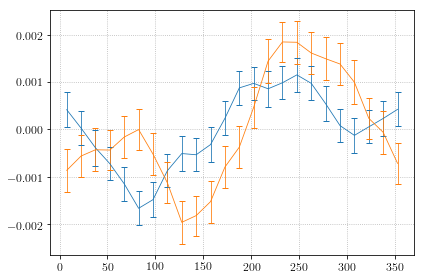

In [14]:
kwargs_relint = {'smooth': 20, 'scale': None, 'decmax': -55}

file_0 = infiles_sample_0[0]
print(file_0)
file_1 = infiles_sample_1[0]

relint_0 = anisotropy.get_map(files=file_0, name='relint', **kwargs_relint)
relint_1 = anisotropy.get_map(files=file_1, name='relint', **kwargs_relint)

relerr_0 = anisotropy.get_map(files=file_0, name='relerr', **kwargs_relint)
relerr_1 = anisotropy.get_map(files=file_1, name='relerr', **kwargs_relint)

ri_0, ri_err_0, ra, ra_err = anisotropy.get_proj_relint(relint_0, relerr_0, n_bins=24)
ri_1, ri_err_1, ra, ra_err = anisotropy.get_proj_relint(relint_1, relerr_1, n_bins=24)

plt.errorbar(ra, ri_0, yerr=ri_err_0)
plt.errorbar(ra, ri_1, yerr=ri_err_1)
plt.grid()
plt.show()

In [4]:
kwargs_data = {'config': config, 'low_energy': low_energy, 'smooth': False, 'scale': False, 'decmax': decmax}

In [14]:
n_total = anisotropy.get_num_events(config=config, composition='all', decmax=decmax)
n_light = anisotropy.get_num_events(config=config, composition='light', decmax=decmax)
n_heavy = anisotropy.get_num_events(config=config, composition='heavy', decmax=decmax)

In [15]:
n_light/n_total, n_heavy/n_total

(0.61598432615372278, 0.38401543147863343)

In [69]:
data_heavy = anisotropy.get_map('data', composition='heavy', **kwargs_data)
data_heavy[ data_heavy < 0 ] = 0
'{:g}'.format(data_heavy.sum())

'1.1091e+07'

In [36]:
kwargs_relint = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': scale, 'decmax': decmax}

In [37]:
relint_all = anisotropy.get_map('relint', composition='all', **kwargs_relint)
relint_light = anisotropy.get_map('relint', composition='light', **kwargs_relint)
relint_heavy = anisotropy.get_map('relint', composition='heavy', **kwargs_relint)

2.8661449384
-3.43987296025


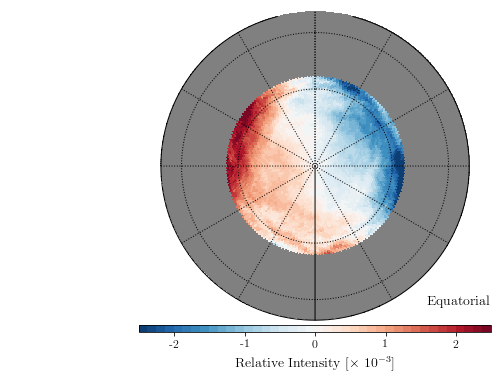

In [38]:
print(rel_int_all.max())
print(rel_int_all[rel_int_all != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_all, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

4.28225073662
-3.7855295012


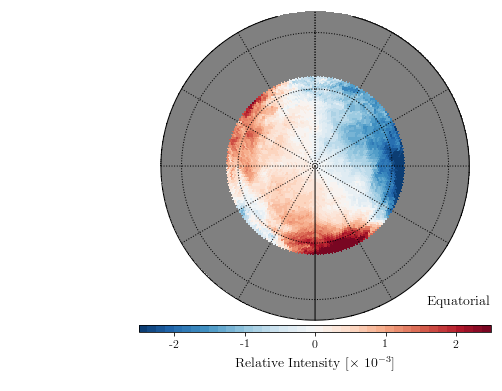

In [39]:
print(rel_int_light.max())
print(rel_int_light[rel_int_light != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_light, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'light', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

2.59085836656
-3.28462140504


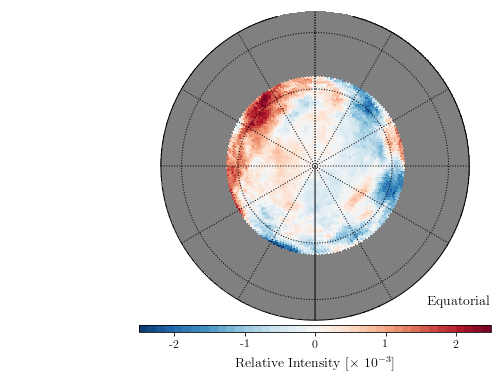

In [40]:
print(rel_int_heavy.max())
print(rel_int_heavy[rel_int_heavy != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_heavy, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'heavy', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [46]:
kwargs_sig = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': None, 'decmax': decmax}

In [47]:
sig_all = anisotropy.get_map('sig', composition='all', **kwargs_sig)
sig_light = anisotropy.get_map('sig', composition='light', **kwargs_sig)
sig_heavy = anisotropy.get_map('sig', composition='heavy', **kwargs_sig)

4.74007594155
-5.26517211233


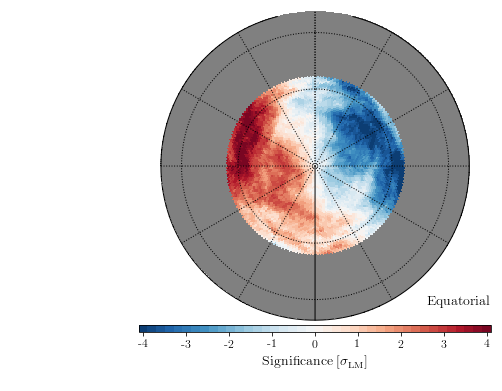

In [48]:
print(sig_all.max())
print(sig_all[sig_all != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_all, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2015', 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

5.55383911119
-4.48361748687


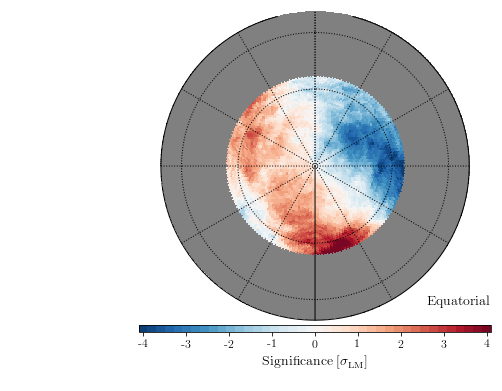

In [49]:
print(sig_light.max())
print(sig_light[sig_light != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_light, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2015', 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'light', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

3.15578385989
-2.85770816159


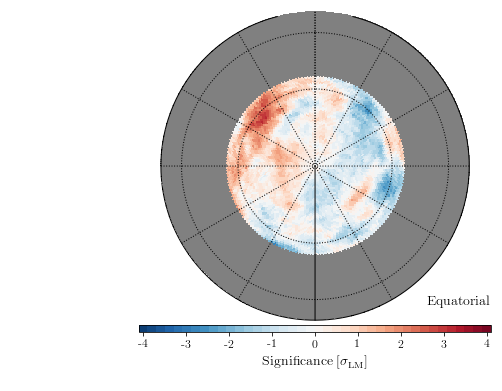

In [50]:
print(sig_heavy.max())
print(sig_heavy[sig_heavy != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_heavy, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2015', 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'heavy', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [30]:
rel_int_diff = anisotropy.get_relint_diff(**kwargs_relint)
print(rel_int_diff.max())
print(rel_int_diff[rel_int_diff != hp.UNSEEN].min())

2.38421078863
-2.57748060774


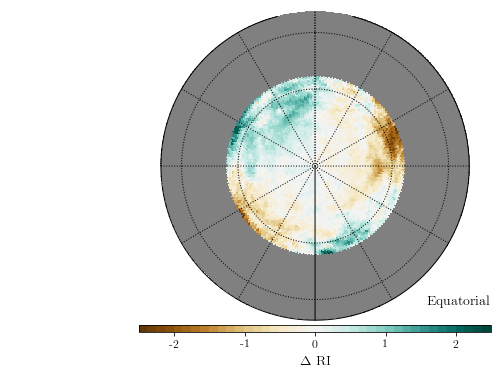

In [31]:
title = '$\mathrm{\Delta \ RI}$'
fig, ax = anisotropy.plot_skymap(rel_int_diff, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='BrBG', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_RI-diff_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

# Projected relative intensity
[ [back to top](#top) ]

In [4]:
kwargs_relint = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': None, 'decmax': decmax}

In [5]:
relint_all = anisotropy.get_map('relint', composition='all', **kwargs_relint)
relint_all_err = anisotropy.get_map('relerr', composition='all', **kwargs_relint)

In [80]:
ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint_all, relint_all_err, n_bins=30)

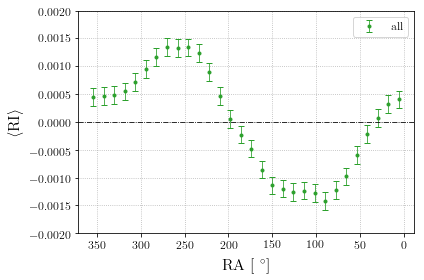

In [81]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', c='C2', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
ax.set_ylim(-2e-3, 2e-3)
ax.invert_xaxis()
ax.legend()
outfile = 'IC86-{}_proj-RI-all_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

In [82]:
relint_light = anisotropy.get_map('relint', composition='light', **kwargs_relint)
relint_light_err = anisotropy.get_map('relerr', composition='light', **kwargs_relint)
ri_light, ri_light_err, ra, ra_err = anisotropy.get_proj_relint(relint_light, relint_light_err, n_bins=30)

In [83]:
relint_heavy = anisotropy.get_map('relint', composition='heavy', **kwargs_relint)
relint_heavy_err = anisotropy.get_map('relerr', composition='heavy', **kwargs_relint)
ri_heavy, ri_heavy_err, ra, ra_err = anisotropy.get_proj_relint(relint_heavy, relint_heavy_err, n_bins=30)

In [84]:
popt_light, perr_light, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_light, sigmay=ri_light_err, l=3)
popt_heavy, perr_heavy, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_heavy, sigmay=ri_heavy_err, l=3)

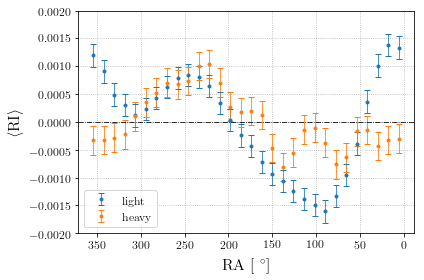

In [85]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)
outfile = 'IC86-{}_proj-RI-comps_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

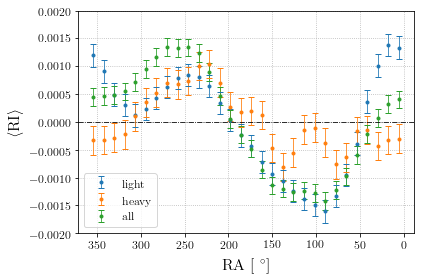

In [86]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)
outfile = 'IC86-{}_proj-RI_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

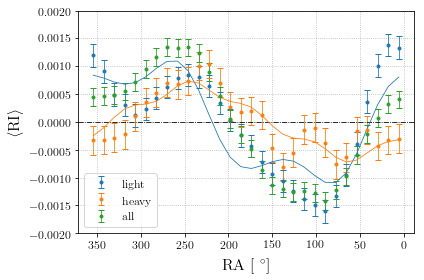

In [87]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_light), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_heavy), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)
outfile = 'IC86-{}_proj-RI-fit_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

In [88]:
amp_light = popt_light[1]
amp_heavy = popt_heavy[1]
amp_err_light = perr_light[1]
amp_err_heavy = perr_heavy[1]

phase_light = np.rad2deg(popt_light[2])
phase_heavy = np.rad2deg(popt_heavy[2])
phase_err_light = np.rad2deg(perr_light[2])
phase_err_heavy = np.rad2deg(perr_heavy[2])

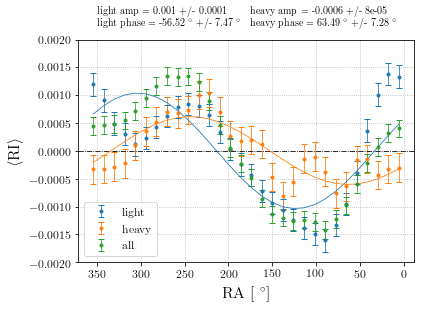

In [89]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_light[:3]), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_heavy[:3]), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)

light_amp_str = 'light amp = {:0.1g} +/- {:0.1g}'.format(amp_light, amp_err_light)
light_phase_str = 'light phase = {:0.2f} {} +/- {:0.2f} {}'.format(phase_light, '$^{\circ}$', phase_err_light, '$^{\circ}$')
ax.text(350, 0.00225, light_amp_str + '\n' + light_phase_str)

heavy_amp_str = 'heavy amp = {:0.1g} +/- {:0.1g}'.format(amp_heavy, amp_err_heavy)
heavy_phase_str = 'heavy phase = {:0.2f} {} +/- {:0.2f} {}'.format(phase_heavy, '$^{\circ}$', phase_err_heavy, '$^{\circ}$')
ax.text(175, 0.00225, heavy_amp_str + '\n' + heavy_phase_str)

outfile = 'IC86-{}_proj-RI-dipolefit_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

# Cross-check: random splitting of events
[ [back to top](#top) ]

In [66]:
config = ['IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
n_side = 64
smooth_rad = 20.0
scale = 3
decmax = -55
figures_dir = '/home/jbourbeau/public_html/figures/composition-anisotropy/cross-check-random-split'
years_str = '2012-2015'

In [67]:
rel_int_0 = anisotropy.get_map('relint', config=config, composition='random_0',
                             smooth=smooth_rad, scale=scale, decmax=decmax)
rel_int_1 = anisotropy.get_map('relint', config=config, composition='random_1',
                             smooth=smooth_rad, scale=scale, decmax=decmax)
print(rel_int_0.max())
print(rel_int_0[rel_int_0 != hp.UNSEEN].min())

print(rel_int_1.max())
print(rel_int_1[rel_int_1 != hp.UNSEEN].min())

2.65429851244
-3.36021713829
2.58918508496
-3.14294109658


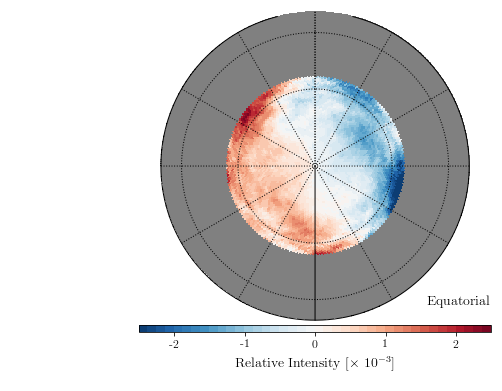

In [68]:
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(rel_int_0, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_0', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

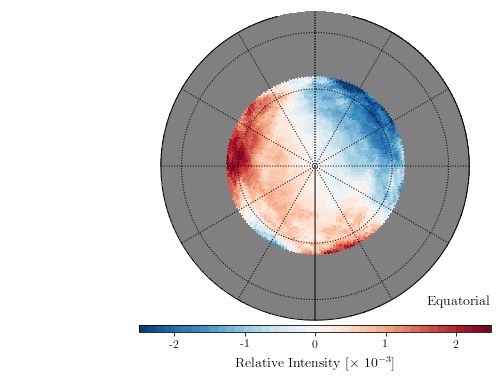

In [69]:
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(rel_int_1, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_1', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

In [70]:
sig_0 = anisotropy.get_map('sig', composition='random_0', config=config, smooth=smooth_rad, decmax=decmax)
sig_1 = anisotropy.get_map('sig', composition='random_1', config=config, smooth=smooth_rad, decmax=decmax)

In [71]:
print(sig_0.max())
print(sig_0[sig_0 != hp.UNSEEN].min())

print(sig_1.max())
print(sig_1[sig_1 != hp.UNSEEN].min())

3.10673742569
-3.66635747678
3.68417830318
-3.60931721794


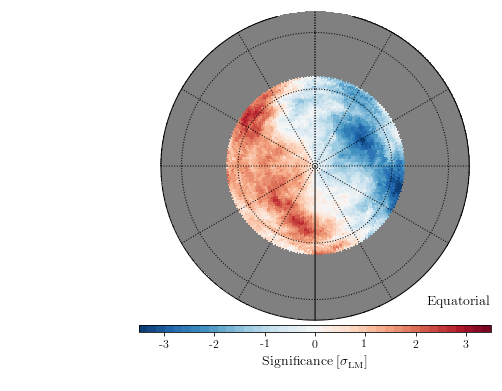

In [72]:
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_0, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-3.5, cbar_max=3.5, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_0', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

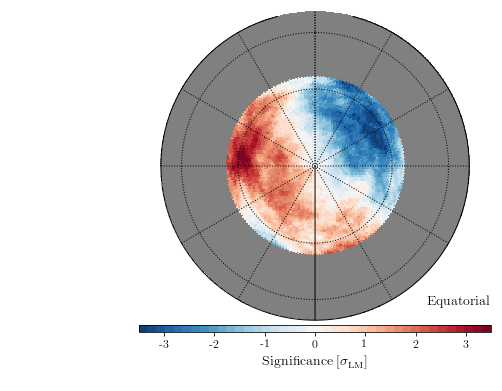

In [73]:
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_1, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-3.5, cbar_max=3.5, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_1', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

In [74]:
relint = anisotropy.get_map('relint', config=config, composition='all',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err = anisotropy.get_map('relerr', config=config, composition='all',
                             smooth=smooth_rad, scale=None, decmax=decmax)

In [75]:
ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint, relint_err)

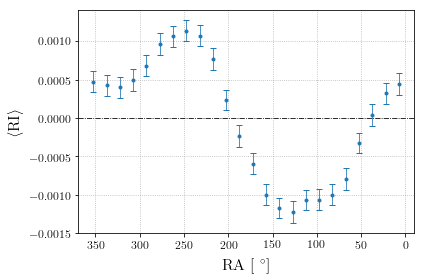

In [76]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
ax.invert_xaxis()
plt.show()

In [91]:
relint_0 = anisotropy.get_map('relint', config=config, composition='random_0',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err_0 = anisotropy.get_map('relerr', config=config, composition='random_0',
                             smooth=smooth_rad, scale=None, decmax=decmax)
ri_0, ri_err_0, ra, ra_err = anisotropy.get_proj_relint(relint_0, relint_err_0)

In [92]:
relint_1 = anisotropy.get_map('relint', config=config, composition='random_1',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err_1 = anisotropy.get_map('relerr', config=config, composition='random_1',
                             smooth=smooth_rad, scale=None, decmax=decmax)
ri_1, ri_err_1, ra, ra_err = anisotropy.get_proj_relint(relint_1, relint_err_1)

In [93]:
popt_0, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_0, sigmay=ri_err_0)
popt_1, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_1, sigmay=ri_err_1)

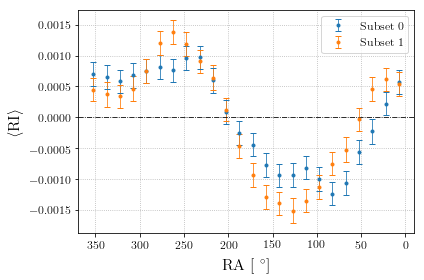

In [94]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

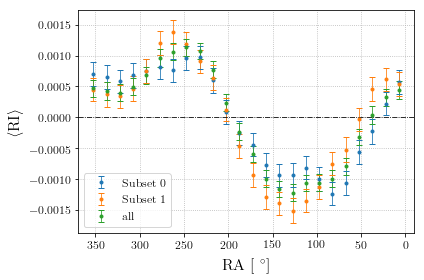

In [95]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

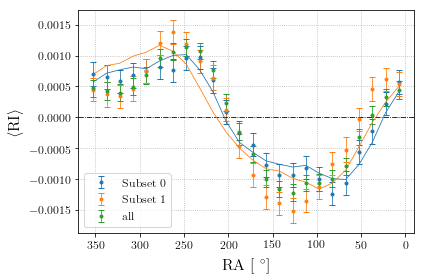

In [96]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_0), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_1), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

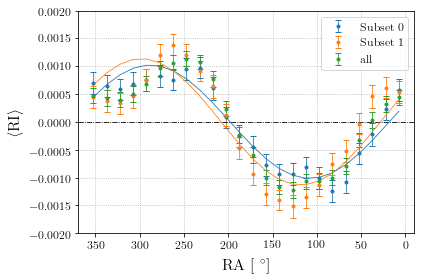

In [97]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_0[:3]), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_1[:3]), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)
outfile = 'IC86-{}_proj-RI-dipolefit_random_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))
plt.show()

In [98]:
'{:g}'.format(popt_0[1]), '{:g}'.format(popt_1[1])

('0.0010178', '0.00113404')

In [99]:
np.rad2deg(popt_0[2]), np.rad2deg(popt_1[2])

(-71.862836300904505, -61.870525912281074)

In [3]:
# Load full DataFrame for config
mypaths = comp.get_paths()
df_file = os.path.join(mypaths.comp_data_dir, 'IC86.2013' + '_data',
                       'anisotropy_dataframe.hdf')
with pd.HDFStore(df_file) as store:
    data_df = store['dataframe']

In [6]:
data_df.head()

,lap_zenith,lap_azimuth,start_time_mjd,pred_comp
0,0.206773,5.480972,56414.452644,light
1,0.181282,2.019701,56414.452706,heavy
2,0.220391,3.160242,56414.452744,heavy
3,0.408630,1.879472,56414.452762,light
4,0.061005,1.460350,56414.452762,light


In [5]:
n_side = 64
n_pix = hp.nside2npix(n_side)
bdt_score_skymap = np.zeros(n_pix)

for idx, row in data_df.iterrows():
    
    local_zenith = row['lap_zenith']
    local_azimuth = row['lap_azimuth']
    local_time = row['start_time_mjd']

    ra, dec = astro.dir_to_equa(local_zenith, local_azimuth, local_time)
    hp_theta, hp_phi = anisotropy.equatorial_to_healpy(ra, dec)
    pix = hp.ang2pix(n_side, hp_theta, hp_phi)
    bdt_score_skymap[pix] += row['score']

KeyError: ('lap_zenith', u'occurred at index lap_zenith')

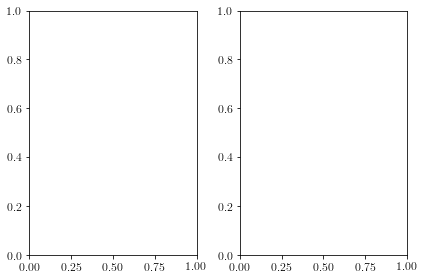

In [80]:
fig, axarr = plt.subplots(1, 2)

In [82]:
ax = axarr[0]

In [ ]:
ax.s